In [1]:
%matplotlib inline
import h5py
import numpy as np
import os
from UG2.models.srnet import SRNet
from UG2.utils import data as data_utils
from UG2.config import Config
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import scipy.ndimage as im
import time
from UG2 import main
import cv2

In [2]:
traindedModels_path  = "/data/UG2_data/trainedModels/"
results_path         = "/mnt/snagesh/ug2challenge/experimentResults/"
validation_data_path = "/data/UG2_data/h5Files/"

In [3]:
factor                = 2
epochsList            = [700]
learningRateList      = [0.001]
testImages            = ['GroundWithShake','GliderWithShake','UAVWithShake']
numberOfExperiments   = len(epochsList)*len(learningRateList)*len(testImages)
nTK                   = 4
flags                 = [1, 1]
validationDatasetName = "BSDBlurred_nTK_"+str(nTK)+ "_flag_" + "_".join([str(f) for f in flags])+"testing"

Using model: modellrRate0_001nEpochs700nTK4.pth
Completed 1 out of 3
Using model: modellrRate0_001nEpochs700nTK4.pth
Completed 2 out of 3
Using model: modellrRate0_001nEpochs700nTK4.pth
Completed 3 out of 3
Completed validation images experiment


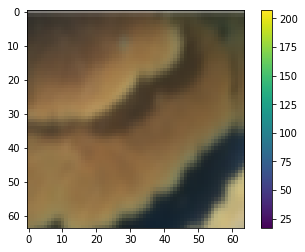

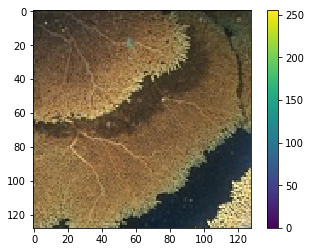

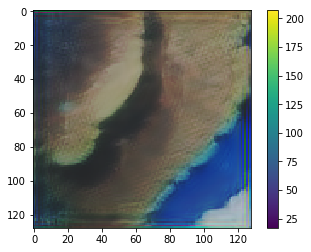

In [4]:
trainStartIndex = 0
numberCompletedExperiments = 0
config = Config()
trainStartIndex = 0
for i in range(trainStartIndex, len(epochsList)):
    for nLR in learningRateList: 
        for testImageName in testImages:
            config.cuda = True
            config.data_parallel = True
            config.model_path = traindedModels_path
            config.model_name = "modellrRate"+str(nLR).replace(".","_")+"nEpochs"+str(epochsList[i])+"nTK"+str(nTK)+".pth"
            print("Using model: "+config.model_name)
            config.hist_eq = True
            filename = results_path+"/output"+testImageName+"lrRate"+str(nLR).replace(".","_")+"nEpochs"+str(epochsList[i-1])+".png"
            
            img_path = "/mnt/snagesh/ug2challenge/performer-packet/evaluation-images/"+testImageName+".jpg"
            img = im.imread(img_path).astype(np.float32)/255.0
            img = np.transpose(img, (2, 0, 1))
            img = img[np.newaxis, :, :, :]
            out = main.test_single(img, config)
            
            cv2.imwrite(filename, (np.transpose(out[0], (1, 2, 0))*255.0).astype(np.uint8))
            numberCompletedExperiments = numberCompletedExperiments+1
            print("Completed "+str(numberCompletedExperiments)+" out of "+str(numberOfExperiments))
            
        with h5py.File(os.path.join(validation_data_path, validationDatasetName + ".h5"),'r') as file:
            label = np.array(file["label"])
            data  = np.array(file["data"])
            for imageIndex in range(1):
                testImage    = data[imageIndex]
                testImage    = np.transpose(testImage.astype(np.uint8), (1, 2, 0))
                plt.figure()
                plt.imshow(testImage)
                plt.colorbar()
                filename     = results_path+"/validationImage"+str(imageIndex)+"lrRate"+str(nLR).replace(".","_")+"nEpochs"+str(epochsList[i-1])+".png"
                cv2.imwrite(filename, (testImage*255.0).astype(np.uint8))

                
                GTImage    = label[imageIndex]
                GTImage    = np.transpose(GTImage.astype(np.uint8), (1, 2, 0))
                plt.figure()
                plt.imshow(GTImage)
                plt.colorbar()
                filename     = results_path+"/validationImageGT"+str(imageIndex)+"lrRate"+str(nLR).replace(".","_")+"nEpochs"+str(epochsList[i-1])+".png"
                cv2.imwrite(filename, (GTImage*255.0).astype(np.uint8))

                testImage    = np.transpose(testImage, (2, 1, 0))
                testImage    = testImage[np.newaxis, :, :, :]
                outputImage  = main.test_single(testImage, config)
                outputImage  = np.transpose(outputImage[0],(1,2,0))
                plt.figure()
                plt.imshow(outputImage.astype(np.uint8))
                plt.colorbar()
                filename     = results_path+"/validationImageOutput"+str(imageIndex)+"lrRate"+str(nLR).replace(".","_")+"nEpochs"+str(epochsList[i-1])+".png"
                cv2.imwrite(filename, outputImage.astype(np.uint8))
            print("Completed validation images experiment")
            